In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt

In [2]:
df = pd.read_csv('Illinois_2021.csv', low_memory=False)

In [3]:
##################################################################################################

In [4]:
##### CLEANING #####

In [5]:
# DROPPING COLUMNS WITH NO VALUE
df.drop(['activity_year','state_code','census_tract','county_code','loan_type','derived_ethnicity',
         'derived_race','derived_sex', 'denial_reason-1','denial_reason-2','denial_reason-3','denial_reason-4',
         'applicant_age_above_62','co-applicant_age_above_62','tract_to_msa_income_percentage','prepayment_penalty_term','intro_rate_period'], axis = 1, inplace = True)

In [6]:
###### MODEL1: OUTPUT = APPLICATION STATUS ######

In [7]:
# Filter the DF so that only accept or reject outcomes are present
df = df[df['action_taken'].isin([1,2,3])]

In [8]:
# Turning the Application outcome (action_taken) into dummy variables
df['action_taken'] = np.where((df['action_taken']==1)|(df['action_taken']==2),1,0)

In [9]:
# Filtering for only Home Purchase Loans
df = df[df['loan_purpose']==1].drop('loan_purpose',axis = 1)
# Filtering for only mortgage applications and NOT covered loans
df = df[df['submission_of_application']!=3]
df = df[df['initially_payable_to_institution']!=3]
# NOT REVERSE MORTGAGE OR OPEN LINE OF CREDIT
df = df[df['reverse_mortgage']==2].drop('reverse_mortgage',axis = 1)
df = df[df['open-end_line_of_credit']==2].drop('open-end_line_of_credit',axis = 1)
#preapproval clean up 
df['preapproval'] = np.where(df['preapproval']==1,1,0)

In [10]:
# DROPPING COLUMNS NOT OF INTEREST
# CANNOT TURN INTO DUMMY
# + Dropping columns with no additional value (usually lot of blanks or not applicable)
df = df.drop(['applicant_ethnicity-2','applicant_ethnicity-3','applicant_ethnicity-4',
                   'applicant_ethnicity-5','co-applicant_ethnicity-2','co-applicant_ethnicity-3',
                   'co-applicant_ethnicity-4','co-applicant_ethnicity-5', 'applicant_race-2','applicant_race-3',
                    'applicant_race-4','applicant_race-5','co-applicant_race-2','co-applicant_race-3',
                    'co-applicant_race-4','co-applicant_race-5','aus-2','aus-3','aus-4','aus-5','multifamily_affordable_units',
                  'manufactured_home_land_property_interest','manufactured_home_secured_property_type',
                    'lien_status','negative_amortization','interest_only_payment','balloon_payment','other_nonamortizing_features',
                  'construction_method'], axis = 1)

# Dropping columns that are only applicable to succesful applications
df.drop(['interest_rate','rate_spread','purchaser_type','initially_payable_to_institution','total_loan_costs',
        'total_points_and_fees','discount_points','lender_credits','origination_charges'], axis = 1, inplace = True)
df = df.reset_index(drop = True)

In [11]:
#### EXPLORING PROPERTY AND AREA RELATED FEATURES WITH SUCCESS RATE ###

In [12]:
### MSA CODE: 5 digit metropolitan statistical area or metropolitan division code: min 50K population

In [13]:
# MSA Code Success Rate 
msa = pd.DataFrame(df.groupby('derived_msa-md')['action_taken'].value_counts())
msa.columns = ['Count']
msa = msa.reset_index()
msa['%'] = 100 * msa['Count'] / msa.groupby('derived_msa-md')['Count'].transform('sum')
msa = msa.sort_values(['derived_msa-md', 'action_taken'], ascending = False).set_index(['derived_msa-md','action_taken'])
msa

Count          %
derived_msa-md action_taken                   
99999          1              13428  88.651218
               0               1719  11.348782
44100          1               3744  93.088016
               0                278   6.911984
41180          1              11529  91.908482
               0               1015   8.091518
40420          1               5276  91.788448
               0                472   8.211552
37900          1               7199  94.661407
               0                406   5.338593
29404          1              13091  93.580671
               0                898   6.419329
28100          1               1322  86.011711
               0                215  13.988289
20994          1              14408  93.765456
               0                958   6.234544
19500          1               1558  89.953811
               0                174  10.046189
19340          1               3227  92.596844
               0                258   7.403156
19180          1                653  87.416332
               0                 94  12.583668
16984          1             112095  91.848022
               0               9949   8.151978
16580          1               3042  92.462006
               0                248   7.537994
16060          1               1209  85.683912
               0                202  14.316088
16020          1                 17  44.736842
               0                 21  55.263158
14010          1               3106  91.111763
               0                303   8.888237
0              1                213  16.075472
               0               1112  83.924528

In [14]:
# NEW FEATURE: In MSA 16984 or not in 16984: are houses within (Chicago, Naperville, Evanston) more succesful?
itopmsa = pd.DataFrame(df[['derived_msa-md','action_taken']])
itopmsa['intopmsa'] = ''
itopmsa['intopmsa'] = np.where(itopmsa['derived_msa-md']!= 16984,0,1)
itopmsa = itopmsa.drop('derived_msa-md',axis = 1)
# Comparison of overall success %
topmsa = pd.DataFrame(itopmsa.groupby('intopmsa')['action_taken'].value_counts())
topmsa.columns = ['Count']
topmsa = topmsa.reset_index()
topmsa['%'] = 100 * topmsa['Count'] / topmsa.groupby('intopmsa')['Count'].transform('sum')
topmsa = topmsa.sort_values(['intopmsa', 'action_taken'], ascending = False).set_index(['intopmsa','action_taken'])
topmsa

Count          %
intopmsa action_taken                   
1        1             112095  91.848022
         0               9949   8.151978
0        1              83022  90.838667
         0               8373   9.161333

Text(0.5, 1.0, 'Success vs Rejection for 16580 MSA code or not')

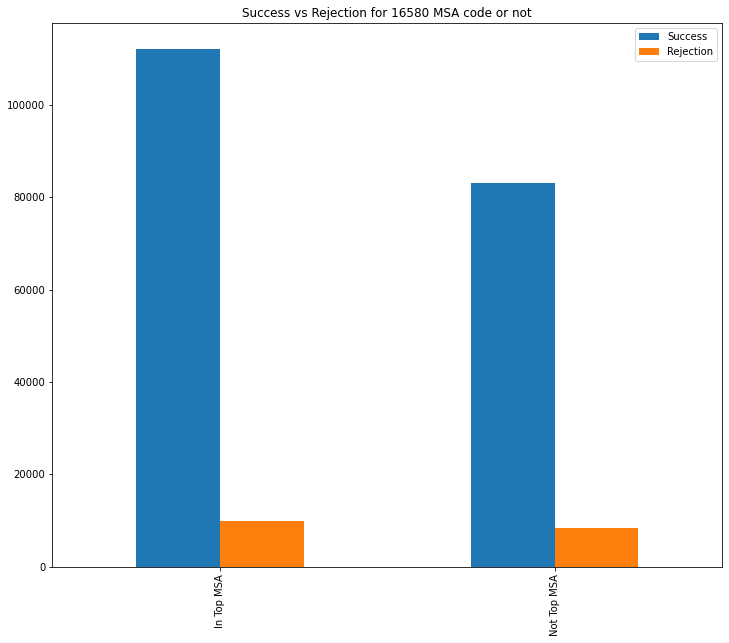

In [15]:
# Comparing Not 16580 vs 16580 Success Rates: graph
graph_topmsa = pd.concat([pd.DataFrame([itopmsa.groupby('intopmsa')['action_taken'].value_counts()[1][1],itopmsa.groupby('intopmsa')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([itopmsa.groupby('intopmsa')['action_taken'].value_counts()[0][1],itopmsa.groupby('intopmsa')['action_taken'].value_counts()[0][0]]).transpose()])
graph_topmsa.index = ['In Top MSA','Not Top MSA']
graph_topmsa.columns = ['Success','Rejection']

graph_topmsa.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for 16580 MSA code or not")

In [16]:
# HYPOTHESIS TESTING : IN TOP MSA > SUCCESS THAN NOT?
population = topmsa.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['In Top MSA %','Not Top MSA %','PVal']
testresult.index = ['']
testresult

,In Top MSA %,Not Top MSA %,PVal
,91.848,90.839,0.000000


In [17]:
### Occupancy Type: 1 is principal residence, 2 is secondary, 3 is investment

In [18]:
# distribution of occupancy type applications
df['occupancy_type'].value_counts()

1    196502
3     13850
2      3087
Name: occupancy_type, dtype: int64

In [19]:
# Occupancy Type + Success Rate
ot = pd.DataFrame(df.groupby('occupancy_type')['action_taken'].value_counts())
ot.columns = ['Count']
ot = ot.reset_index()
ot['%'] = 100 * ot['Count'] / ot.groupby('occupancy_type')['Count'].transform('sum')
ot = ot.sort_values(['occupancy_type', 'action_taken'], ascending = False).set_index(['occupancy_type','action_taken'])
ot

Count          %
occupancy_type action_taken                   
3              1              12597  90.953069
               0               1253   9.046931
2              1               2834  91.804341
               0                253   8.195659
1              1             179686  91.442326
               0              16816   8.557674

Text(0.5, 1.0, 'Success vs Rejection for Occupancy Types')

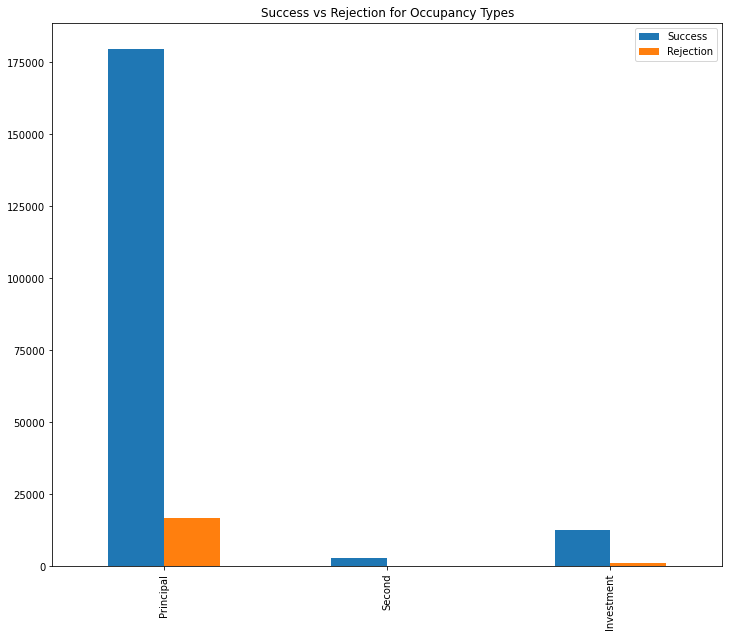

In [20]:
# Comparing Occupancy Type 1-2-3  Success Rates
# Comparing Occupancy Type Success Rates: graph
graph_ot = pd.concat([pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[1][1],df.groupby('occupancy_type')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[2][1],df.groupby('occupancy_type')['action_taken'].value_counts()[2][0]]).transpose(),
           pd.DataFrame([df.groupby('occupancy_type')['action_taken'].value_counts()[3][1],df.groupby('occupancy_type')['action_taken'].value_counts()[3][0]]).transpose()])

graph_ot.index = ['Principal','Second','Investment']
graph_ot.columns = ['Success','Rejection']

graph_ot.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Occupancy Types")

In [21]:
# HYPOTHESIS TESTING : Occupancy Type impact on success?
population = ot.reset_index()

testresult = pd.DataFrame()
testresult['Investment %'] = list([round(population.iloc[0][3],3)]) 
testresult['Second %'] = list([round(population.iloc[2][3],3)])
testresult['Principal %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Investment vs Second','Investment vs Principal', 'Second vs Principal']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Investment %,Second %,Principal %,Investment vs Second,Investment vs Principal,Second vs Principal
,90.953,91.804,91.442,0.150247,0.058172,0.494125


In [22]:
## PROPERTY VALUE ##

In [23]:
# DROP ALL THAT HAVE AN EXEMPT / NOT NUMERIC
numeric_value = pd.DataFrame(df['action_taken'])
numeric_value['property_value'] = pd.to_numeric(df['property_value'], errors='coerce')
numeric_value = numeric_value.dropna().reset_index(drop = True)
len(df)-len(numeric_value)

2029

In [24]:
# Creating Buckets for Property Values
low = numeric_value['property_value'].quantile(.33)
medium = numeric_value['property_value'].quantile(.66)
numeric_value['Value_Bracket'] = np.where(numeric_value['property_value']<=low,'Low',
         np.where((numeric_value['property_value']>low)&(numeric_value['property_value']<medium),'Medium',
                 np.where(numeric_value['property_value']>=medium,'High','ERROR')))

print('Low: Property Value <=',low)
print('Medium: Property Value >',low,'and <',medium)
print('High: Property Value >=',medium)

Low: Property Value <= 195000.0
Medium: Property Value > 195000.0 and < 325000.0
High: Property Value >= 325000.0


In [25]:
# Value Bracket + Success Rate
vb = pd.DataFrame(numeric_value.groupby('Value_Bracket')['action_taken'].value_counts())
vb.columns = ['Count']
vb = vb.reset_index()
vb['%'] = 100 * vb['Count'] / vb.groupby('Value_Bracket')['Count'].transform('sum')
vb = vb.sort_values(['Value_Bracket', 'action_taken'], ascending = False).set_index(['Value_Bracket','action_taken'])
vb

Count          %
Value_Bracket action_taken                  
Medium        1             58138  92.595601
              0              4649   7.404399
Low           1             65791  88.273336
              0              8740  11.726664
High          1             70335  94.929277
              0              3757   5.070723

Text(0.5, 1.0, 'Success vs Rejection for Property Value Bracket')

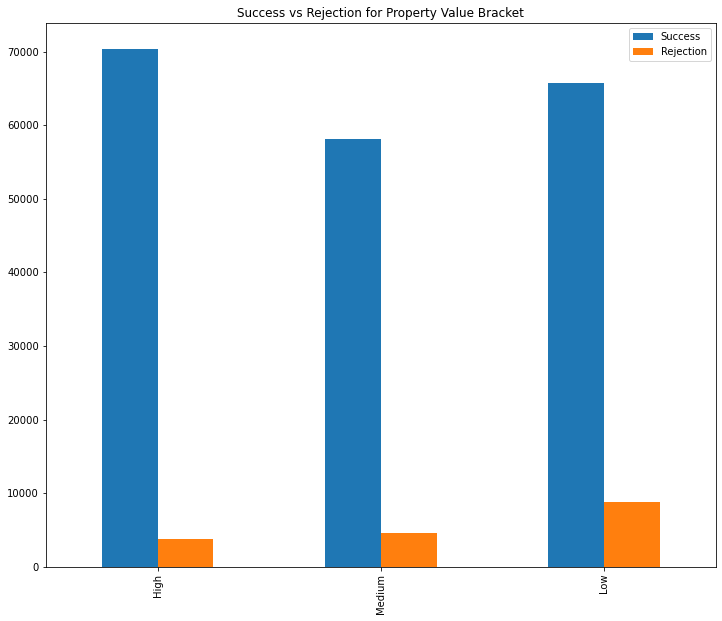

In [26]:
# Comparing Value Brackets Property Success Rates
graph_vb = pd.concat([pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['High'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][1],numeric_value.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_vb.index = ['High','Medium','Low']
graph_vb.columns = ['Success','Rejection']

graph_vb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Property Value Bracket")

In [27]:
# HYPOTHESIS TESTING : Property Value Brackets impact on success?
population = vb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.596,88.273,94.929,0.000000,0.000000,0.000000


In [28]:
# TRACT POPULATION #

In [29]:
# Creating Buckets for Tract population
tract = pd.DataFrame(df[['tract_population','action_taken']])

low = tract['tract_population'].quantile(.33)
medium = tract['tract_population'].quantile(.66)
tract['Population_Bracket'] = np.where(tract['tract_population']<=low,'Low',
         np.where((tract['tract_population']>low)&(tract['tract_population']<medium),'Medium',
                 np.where(tract['tract_population']>=medium,'High','ERROR')))

print('Low: Population <=',low)
print('Medium: Population >',low,'and <',medium)
print('High: Population >=',medium)

Low: Population <= 4054.0
Medium: Population > 4054.0 and < 5652.0
High: Population >= 5652.0


In [30]:
# Population Bracket + Success Rate
pb = pd.DataFrame(tract.groupby('Population_Bracket')['action_taken'].value_counts())
pb.columns = ['Count']
pb = pb.reset_index()
pb['%'] = 100 * pb['Count'] / pb.groupby('Population_Bracket')['Count'].transform('sum')
pb = pb.sort_values(['Population_Bracket', 'action_taken'], ascending = False).set_index(['Population_Bracket','action_taken'])
pb

Count          %
Population_Bracket action_taken                  
Medium             1             64801  92.188300
                   0              5491   7.811700
Low                1             63000  89.417509
                   0              7456  10.582491
High               1             67316  92.605687
                   0              5375   7.394313

Text(0.5, 1.0, 'Success vs Rejection for Population Bracket')

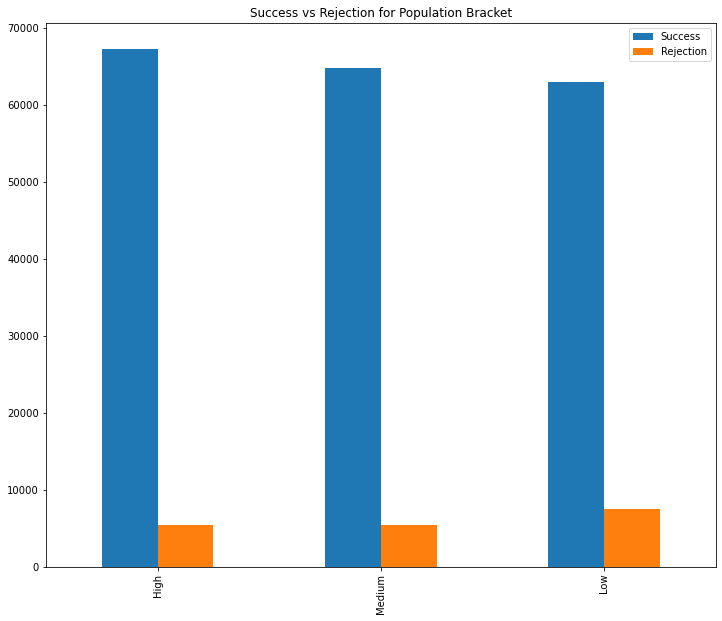

In [31]:
# Comparing Population Success Rates
graph_pb = pd.concat([pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['High'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['Medium'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([tract.groupby('Population_Bracket')['action_taken'].value_counts()['Low'][1],tract.groupby('Population_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_pb.index = ['High','Medium','Low']
graph_pb.columns = ['Success','Rejection']

graph_pb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Population Bracket")

In [32]:
# HYPOTHESIS TESTING : Population impact on success?
population = pb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.188,89.418,92.606,0.000000,0.004208,0.000000


In [33]:
# Tract Minority Population #

In [34]:
# Creating Buckets for Minority %
minority_tract = pd.DataFrame(df[['tract_minority_population_percent','action_taken']])

low = minority_tract['tract_minority_population_percent'].quantile(.33)
medium = minority_tract['tract_minority_population_percent'].quantile(.66)
minority_tract['Minority_Population_Bracket'] = np.where(minority_tract['tract_minority_population_percent']<=low,'Low',
         np.where((minority_tract['tract_minority_population_percent']>low)&(minority_tract['tract_minority_population_percent']<medium),'Medium',
                 np.where(minority_tract['tract_minority_population_percent']>=medium,'High','ERROR')))

print('Low: Minority Percent <=',low)
print('Medium: Minority Percent >',low,'and <',medium)
print('High: Minority Percent >=',medium)

Low: Minority Percent <= 15.37
Medium: Minority Percent > 15.37 and < 34.41
High: Minority Percent >= 34.41


In [35]:
# Minority % + Success Rate
mpb = pd.DataFrame(minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts())
mpb.columns = ['Count']
mpb = mpb.reset_index()
mpb['%'] = 100 * mpb['Count'] / mpb.groupby('Minority_Population_Bracket')['Count'].transform('sum')
mpb = mpb.sort_values(['Minority_Population_Bracket', 'action_taken'], ascending = False).set_index(['Minority_Population_Bracket','action_taken'])
mpb

Count          %
Minority_Population_Bracket action_taken                  
Medium                      1             65539  93.236880
                            0              4754   6.763120
Low                         1             64341  91.327306
                            0              6110   8.672694
High                        1             65237  89.740697
                            0              7458  10.259303

Text(0.5, 1.0, 'Success vs Rejection for Minority Population Bracket')

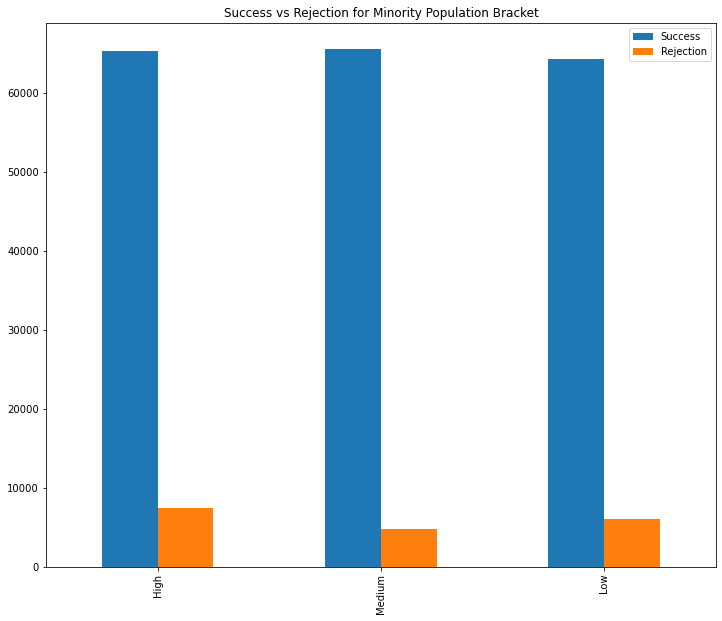

In [36]:
# Comparing Minority % Brackets Success Rates
graph_mpb = pd.concat([pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['High'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Medium'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Low'][1],minority_tract.groupby('Minority_Population_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_mpb.index = ['High','Medium','Low']
graph_mpb.columns = ['Success','Rejection']

graph_mpb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Minority Population Bracket")

In [37]:
# HYPOTHESIS TESTING : Minority % Brackets impact on success?
population = mpb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,93.237,91.327,89.741,0.000000,0.000000,0.000000


In [38]:
#### EXPLORING APPLICANT RELATED FEATURES WITH SUCCESS RATE ###

In [39]:
# Income #

In [40]:
# DROP ALL THAT HAVE A NOT NUMERIC INCOME
numeric_income = pd.DataFrame(df['action_taken'])
numeric_income['income'] = pd.to_numeric(df['income'], errors='coerce')
numeric_income = numeric_income.dropna().reset_index(drop = True)
len(df)-len(numeric_income)

5983

In [41]:
# Creating Buckets for Income 
low = numeric_income['income'].quantile(.33)
medium = numeric_income['income'].quantile(.66)
numeric_income['Income_Bracket'] = np.where(numeric_income['income']<=low,'Low',
         np.where((numeric_income['income']>low)&(numeric_income['income']<medium),'Medium',
                 np.where(numeric_income['income']>=medium,'High','ERROR')))

print('Low: Income <=',low)
print('Medium: Income >',low,'and <',medium)
print('High: Income >=',medium)

Low: Income <= 62.0
Medium: Income > 62.0 and < 106.0
High: Income >= 106.0


In [42]:
# Income Bracket + Success Rate
ib = pd.DataFrame(numeric_income.groupby('Income_Bracket')['action_taken'].value_counts())
ib.columns = ['Count']
ib = ib.reset_index()
ib['%'] = 100 * ib['Count'] / ib.groupby('Income_Bracket')['Count'].transform('sum')
ib = ib.sort_values(['Income_Bracket', 'action_taken'], ascending = False).set_index(['Income_Bracket','action_taken'])
ib

Count          %
Income_Bracket action_taken                  
Medium         1             61783  92.795134
               0              4797   7.204866
Low            1             59854  86.225078
               0              9562  13.774922
High           1             68172  95.398825
               0              3288   4.601175

Text(0.5, 1.0, 'Success vs Rejection for Income Bracket')

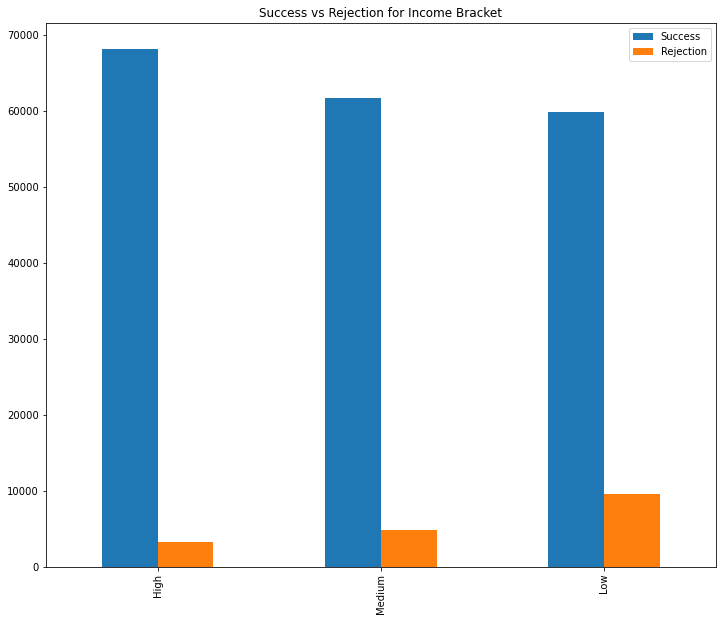

In [43]:
# Comparing Income Brackets Property Success Rates
graph_ib = pd.concat([pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['High'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Low'][1],numeric_income.groupby('Income_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_ib.index = ['High','Medium','Low']
graph_ib.columns = ['Success','Rejection']

graph_ib.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Income Bracket")

In [44]:
# HYPOTHESIS TESTING : Income Brackets impact on success?
population = ib.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult


,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.795,86.225,95.399,0.000000,0.000000,0.000000


In [45]:
# Debt to Income #

In [46]:
# CLEANING UP DEBT TO INCOME!
test=pd.DataFrame(np.where(df['debt_to_income_ratio'].str.contains('%',na = False),df['debt_to_income_ratio'],
        np.where((~df['debt_to_income_ratio'].str.contains('%',na = False))&(~df['debt_to_income_ratio'].str.contains('Exempt',na = False))&(~df['debt_to_income_ratio'].isnull()),'50%-60%',df['debt_to_income_ratio'])))
df['debt_to_income_ratio'] = test

In [47]:
# DROP ALL THAT HAVE AN EXEMPT / blank
numeric_dti = pd.DataFrame(df[['action_taken','debt_to_income_ratio']])
numeric_dti['debt_to_income_ratio'] = np.where(numeric_dti['debt_to_income_ratio']=='Exempt',np.nan,numeric_dti['debt_to_income_ratio'])
numeric_dti = numeric_dti.dropna().reset_index(drop = True)
len(df) - len(numeric_dti)

6100

In [48]:
# DTI Bracket + Success Rate
dti = pd.DataFrame(numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts())
dti.columns = ['Count']
dti = dti.reset_index()
dti['%'] = 100 * dti['Count'] / dti.groupby('debt_to_income_ratio')['Count'].transform('sum')
dti = dti.sort_values(['debt_to_income_ratio', 'action_taken'], ascending = False).set_index(['debt_to_income_ratio','action_taken'])
dti

Count          %
debt_to_income_ratio action_taken                   
>60%                 1                357   9.804999
                     0               3284  90.195001
<20%                 1              12379  88.251230
                     0               1648  11.748770
50%-60%              1             102341  92.416403
                     0               8398   7.583597
30%-<36%             1              35831  95.353541
                     0               1746   4.646459
20%-<30%             1              39317  95.071938
                     0               2038   4.928062

Text(0.5, 1.0, 'Success vs Rejection for DTI Bracket')

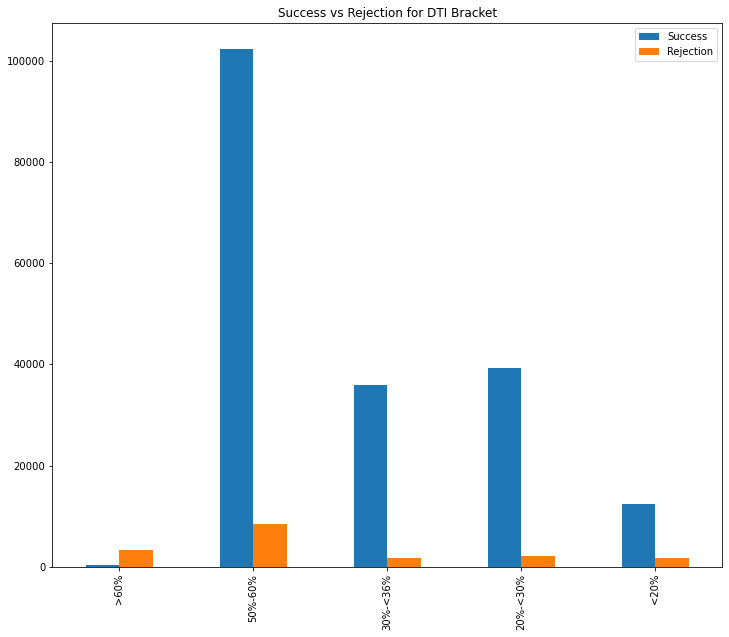

In [49]:
# Comparing DTI Brackets Property Success Rates
graph_dti = pd.concat([pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['>60%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['>60%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['50%-60%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['50%-60%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['30%-<36%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['30%-<36%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['20%-<30%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['20%-<30%'][0]]).transpose(),
           pd.DataFrame([numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['<20%'][1],numeric_dti.groupby('debt_to_income_ratio')['action_taken'].value_counts()['<20%'][0]]).transpose()])

graph_dti.index = ['>60%','50%-60%','30%-<36%','20%-<30%','<20%']
graph_dti.columns = ['Success','Rejection']

graph_dti.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for DTI Bracket")

In [50]:
# HYPOTHESIS TESTING : DTI Brackets impact on success?
population = dti.reset_index()

testresult = pd.DataFrame()
testresult['>60% %'] = list([round(population.iloc[0][3],3)]) 
testresult['<20% %'] = list([round(population.iloc[2][3],3)])
testresult['50%-60% %'] = list([round(population.iloc[4][3],3)])
testresult['30%-<36% %'] = list([round(population.iloc[6][3],3)])
testresult['20%-<30% %'] = list([round(population.iloc[8][3],3)])

columnnames = ['>60 vs <20','>60 vs 50-60', '>60 vs 30-36','>60 vs 20-30','<20 vs 50-60',
              '<20 vs 30-36','<20 vs 20-30','50-60 vs 30-36','50-60 vs 20-30','30-36 vs 20-30']

sample1_phat_list = [0,0,0,0,2,2,2,4,4,6,3,3,3,3,3,3,3,3,3,3]
sample2_phat_list = [2,4,6,8,4,6,8,6,8,8,3,3,3,3,3,3,3,3,3,3]
sample1_size_list = [0,0,0,0,2,2,2,4,4,6,2,2,2,2,2,2,2,2,2,2]
sample2_size_list = [2,4,6,8,4,6,8,6,8,8,2,2,2,2,2,2,2,2,2,2]


for x in range(len(population)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+10]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+10]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+10]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+10]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,>60% %,<20% %,50%-60% %,30%-<36% %,20%-<30% %,>60 vs <20,>60 vs 50-60,>60 vs 30-36,>60 vs 20-30,<20 vs 50-60,<20 vs 30-36,<20 vs 20-30,50-60 vs 30-36,50-60 vs 20-30,30-36 vs 20-30
,9.805,88.251,92.416,95.354,95.072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071108


In [51]:
# Ethnicity #

In [52]:
# CREATING A NEW FIELD: SAME ETHNICITY BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_ethnicity'] = np.where(df['applicant_ethnicity-1']==df['co-applicant_ethnicity-1'],1,0)

# ANALYZING HISPANIC/LATINO VS NOT
hispanic_latino = pd.DataFrame(df['action_taken'])
hispanic_latino['Ethnicity'] = np.where(df['applicant_ethnicity-1']==1,1,np.where(df['applicant_ethnicity-1']==2,0,np.nan))
hispanic_latino = hispanic_latino.dropna().reset_index(drop = True)

In [53]:
# Hispanic/Latino vs not + Success Rate
hl = pd.DataFrame(hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts())
hl.columns = ['Count']
hl = hl.reset_index()
hl['%'] = 100 * hl['Count'] / hl.groupby('Ethnicity')['Count'].transform('sum')
hl = hl.sort_values(['Ethnicity', 'action_taken'], ascending = False).set_index(['Ethnicity','action_taken'])
hl

Count          %
Ethnicity action_taken                   
1.0       1              26745  89.781463
          0               3044  10.218537
0.0       1             144115  92.267259
          0              12078   7.732741

Text(0.5, 1.0, 'Success vs Rejection for Hispanic/Latino or Not')

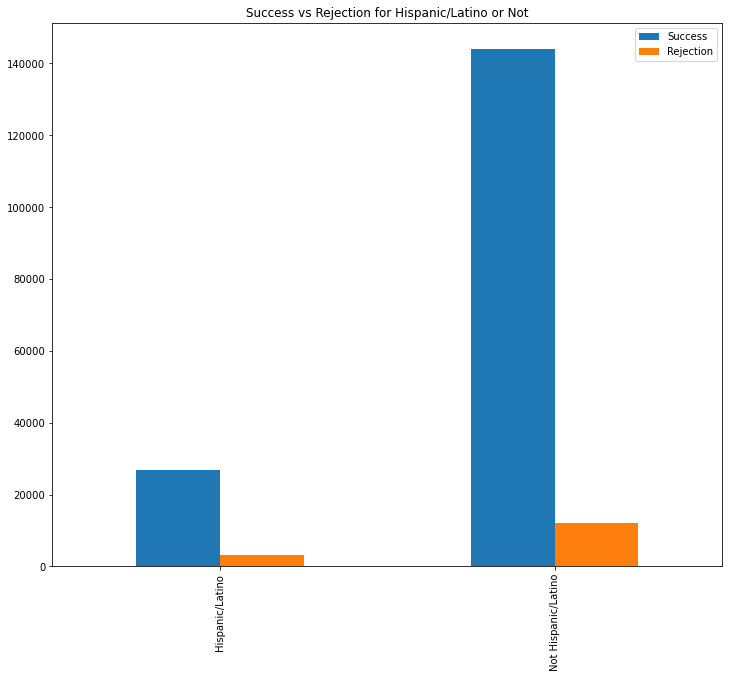

In [54]:
# Comparing Hispanic/Latino vs not Success Rates
graph_hs = pd.concat([pd.DataFrame([hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[1][1],hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[0][1],hispanic_latino.groupby('Ethnicity')['action_taken'].value_counts()[0][0]]).transpose()])
graph_hs.index = ['Hispanic/Latino','Not Hispanic/Latino']
graph_hs.columns = ['Success','Rejection']

graph_hs.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Hispanic/Latino or Not")

In [55]:
# HYPOTHESIS TESTING : IN Hispanic/Latino vs Not
population = hl.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Hispanic or Latino %','Not Hispanic or Latino %','PVal']
testresult.index = ['']
testresult

,Hispanic or Latino %,Not Hispanic or Latino %,PVal
,89.781,92.267,0.000000


In [56]:
# Race #

In [57]:
# CREATING A NEW FIELD: SAME RACE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_race'] = np.where(df['applicant_race-1']==df['co-applicant_race-1'],1,0)

# ANALYZING ONLY BLACK, ASIAN, WHITE (TOP 3)
top3_race = pd.DataFrame(df['action_taken'])
top3_race['Race'] = np.where(df['applicant_race-1']==5,'White',np.where(df['applicant_race-1']==3,'Black',
                                                                        np.where(df['applicant_race-1']==2,'Asian',np.nan)))
top3_race = top3_race.dropna().reset_index(drop = True)
top3_race = top3_race[top3_race['Race']!='nan']

In [58]:
# Top 3 Race + Success Rate
t3r = pd.DataFrame(top3_race.groupby('Race')['action_taken'].value_counts())
t3r.columns = ['Count']
t3r = t3r.reset_index()
t3r['%'] = 100 * t3r['Count'] / t3r.groupby('Race')['Count'].transform('sum')
t3r = t3r.sort_values(['Race', 'action_taken'], ascending = False).set_index(['Race','action_taken'])
t3r

Count          %
Race  action_taken                   
White 1             135818  93.155552
      0               9979   6.844448
Black 1              17842  81.851546
      0               3956  18.148454
Asian 1              13256  93.881020
      0                864   6.118980

Text(0.5, 1.0, 'Success vs Rejection for Top 3 Races')

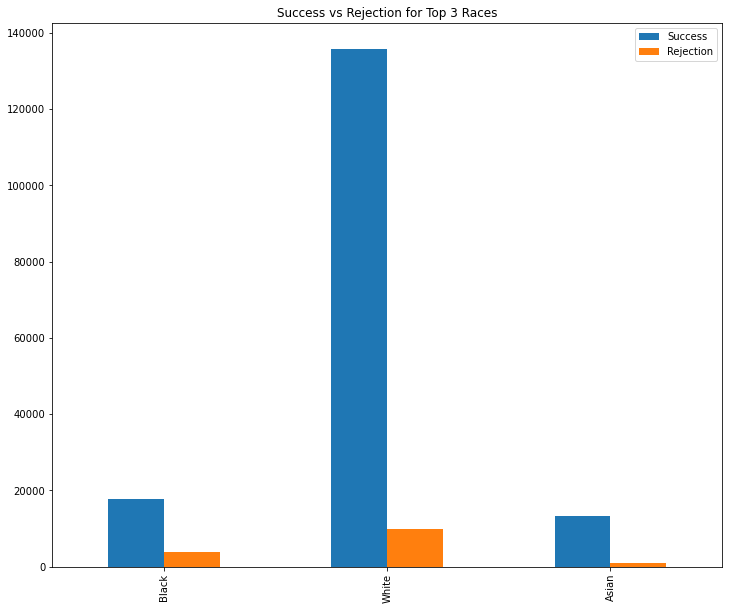

In [59]:
# Comparing Value Brackets Property Success Rates
graph_t3r = pd.concat([pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['Black'][1],top3_race.groupby('Race')['action_taken'].value_counts()['Black'][0]]).transpose(),
           pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['White'][1],top3_race.groupby('Race')['action_taken'].value_counts()['White'][0]]).transpose(),
           pd.DataFrame([top3_race.groupby('Race')['action_taken'].value_counts()['Asian'][1],top3_race.groupby('Race')['action_taken'].value_counts()['Asian'][0]]).transpose()])
graph_t3r.index = ['Black','White','Asian']
graph_t3r.columns = ['Success','Rejection']

graph_t3r.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Top 3 Races")

In [60]:
# HYPOTHESIS TESTING : Top 3 Races impact on success?
population = t3r.reset_index()

testresult = pd.DataFrame()
testresult['White %'] = list([round(population.iloc[0][3],3)]) 
testresult['Black %'] = list([round(population.iloc[2][3],3)])
testresult['Asian %'] = list([round(population.iloc[4][3],3)])

columnnames = ['White vs Black','White vs Asian', 'Black vs Asian']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,White %,Black %,Asian %,White vs Black,White vs Asian,Black vs Asian
,93.156,81.852,93.881,0.000000,0.001518,0.000000


In [61]:
# SEX #

In [62]:
# CREATING A NEW FIELD: SAME RACE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_sex'] = np.where(df['applicant_sex']==df['co-applicant_sex'],1,0)

# ANALYZING Male and Female: Applicant
male_female = pd.DataFrame(df['action_taken'])
male_female['Sex'] = np.where(df['applicant_sex']==1,'Male',np.where(df['applicant_sex']==2,'Female',np.nan))
male_female = male_female.dropna().reset_index(drop = True)
male_female = male_female[male_female['Sex']!='nan']

In [63]:
# Sex + Success Rate
sex = pd.DataFrame(male_female.groupby('Sex')['action_taken'].value_counts())
sex.columns = ['Count']
sex = sex.reset_index()
sex['%'] = 100 * sex['Count'] / sex.groupby('Sex')['Count'].transform('sum')
sex = sex.sort_values(['Sex', 'action_taken'], ascending = False).set_index(['Sex','action_taken'])
sex

Count          %
Sex    action_taken                   
Male   1             113376  92.302432
       0               9455   7.697568
Female 1              70590  90.417697
       0               7481   9.582303

Text(0.5, 1.0, 'Success vs Rejection for Male vs Female')

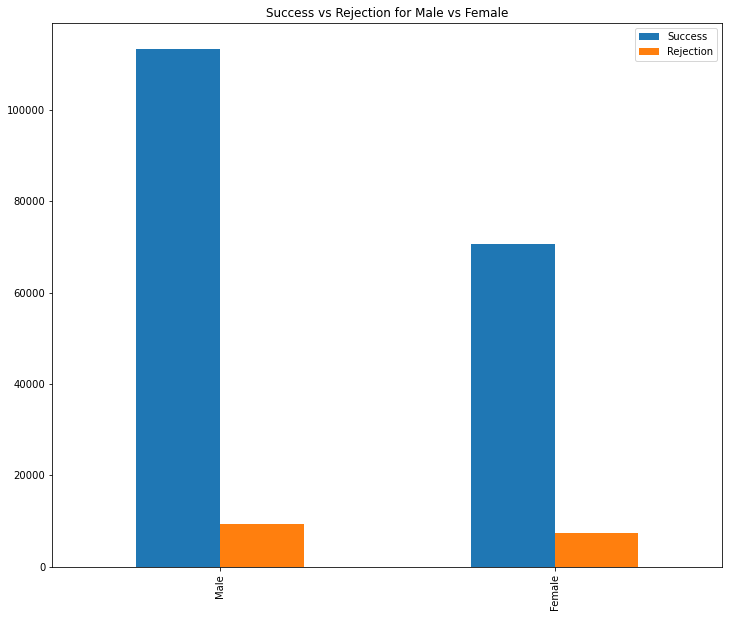

In [64]:
# Comparing Hispanic/Latino vs not Success Rates
graph_sex = pd.concat([pd.DataFrame([male_female.groupby('Sex')['action_taken'].value_counts()['Male'][1],male_female.groupby('Sex')['action_taken'].value_counts()['Male'][0]]).transpose(),
           pd.DataFrame([male_female.groupby('Sex')['action_taken'].value_counts()['Female'][1],male_female.groupby('Sex')['action_taken'].value_counts()['Female'][0]]).transpose()])
graph_sex.index = ['Male','Female']
graph_sex.columns = ['Success','Rejection']

graph_sex.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Male vs Female")

In [65]:
# HYPOTHESIS TESTING : SEX and Success
population = sex.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Male %','Female %','PVal']
testresult.index = ['']
testresult

,Male %,Female %,PVal
,92.302,90.418,0.000000


In [66]:
# AGE #

In [67]:
# CREATING A NEW FIELD: SAME AGE BETWEEN CO APPLICANT AND APPLICANT = 1: NO CO APPLICANT IS ALSO 0
df['same_age'] = np.where(df['applicant_age']==df['co-applicant_age'],1,0)

age_bracket = df[df['applicant_age']!='8888'][['action_taken','applicant_age']]

In [68]:
# Age Bracket + Success Rate
age = pd.DataFrame(age_bracket.groupby('applicant_age')['action_taken'].value_counts())
age.columns = ['Count']
age = age.reset_index()
age['%'] = 100 * age['Count'] / age.groupby('applicant_age')['Count'].transform('sum')
age = age.sort_values(['applicant_age', 'action_taken'], ascending = False).set_index(['applicant_age','action_taken'])
age

Count          %
applicant_age action_taken                  
>74           1              2109  91.655802
              0               192   8.344198
<25           1             11564  89.221511
              0              1397  10.778489
65-74         1              8522  91.792331
              0               762   8.207669
55-64         1             18225  90.088977
              0              2005   9.911023
45-54         1             30905  90.117805
              0              3389   9.882195
35-44         1             54272  91.715956
              0              4902   8.284044
25-34         1             66093  92.637289
              0              5253   7.362711

In [69]:
# NEW AGE BRACKET
new_age = pd.DataFrame(df['action_taken'])
new_age['Age'] = np.where((df['applicant_age']=='25-34')|(df['applicant_age']=='35-44'),1,0)

In [70]:
# age + Success Rate
age = pd.DataFrame(new_age.groupby('Age')['action_taken'].value_counts())
age.columns = ['Count']
age = age.reset_index()
age['%'] = 100 * age['Count'] / age.groupby('Age')['Count'].transform('sum')
age = age.sort_values(['Age', 'action_taken'], ascending = False).set_index(['Age','action_taken'])
age

Count          %
Age action_taken                   
1   1             120365  92.219583
    0              10155   7.780417
0   1              74752  90.150629
    0               8167   9.849371

Text(0.5, 1.0, 'Success vs Rejection for within 25-44 or not')

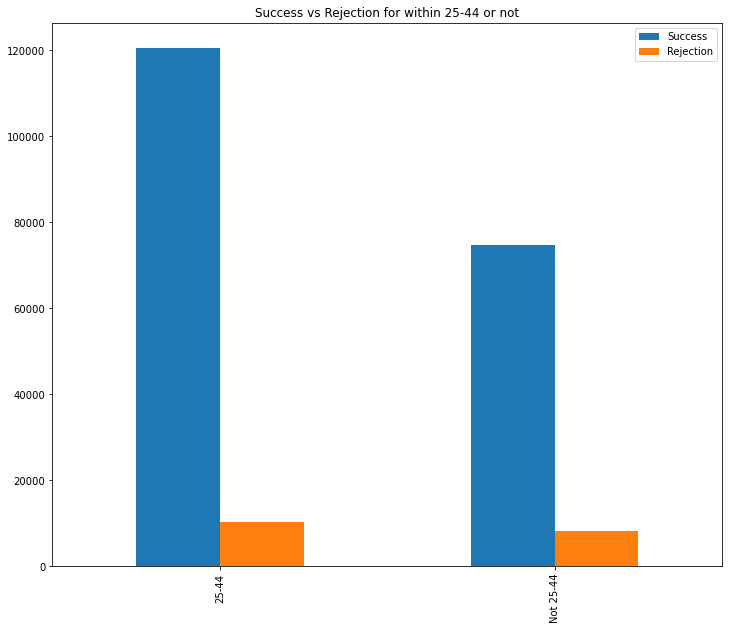

In [71]:
# Comparing Age and Success Rates
graph_age = pd.concat([pd.DataFrame([new_age.groupby('Age')['action_taken'].value_counts()[1][1],new_age.groupby('Age')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([new_age.groupby('Age')['action_taken'].value_counts()[0][1],new_age.groupby('Age')['action_taken'].value_counts()[0][0]]).transpose()])
graph_age.index = ['25-44','Not 25-44']
graph_age.columns = ['Success','Rejection']

graph_age.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for within 25-44 or not")

In [72]:
# HYPOTHESIS TESTING : Age and Success
population = age.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['25-44 %','Not 25-44 %','PVal']
testresult.index = ['']
testresult

,25-44 %,Not 25-44 %,PVal
,92.22,90.151,0.000000


In [73]:
#### EXPLORING APPLICANTION RELATED FEATURES WITH SUCCESS RATE ###

In [74]:
# LEI #

In [75]:
# TOP 15 lenders: Sourced from 2020 HDMA by USA total Issuance count
toplenderlist = ['549300BRJZYHYKT4BJ84','549300AQ3T62GXDU7D76','549300U3721PJGQZYY68',
                '549300VZVN841I2ILS84','549300LBCBNR1OT00651','6BYL5QZYBDK8S7L73M02','B4TYDEB6GKMZO031MB27',
                '7H6GLXDRUGQFU57RNE97','549300MGPZBLQDIL7538','549300J7XKT2BI5WX213','549300AG64NHILB7ZP05',
                'PBLD0EJDB5FWOLXP3B76','549300LYRWPSYPK6S325','549300HW662MN1WU8550','549300FGXN1K3HLB1R50']
# New Column: top 15 lender or not
df['top15_lender_2020'] = np.where(df['lei'].isin(toplenderlist),1,0)
df = df.drop('lei',axis = 1)
top_lenders = df[['action_taken','top15_lender_2020']]

In [76]:
# Top Lender + Success Rate
tl = pd.DataFrame(top_lenders.groupby('top15_lender_2020')['action_taken'].value_counts())
tl.columns = ['Count']
tl = tl.reset_index()
tl['%'] = 100 * tl['Count'] / tl.groupby('top15_lender_2020')['Count'].transform('sum')
tl = tl.sort_values(['top15_lender_2020', 'action_taken'], ascending = False).set_index(['top15_lender_2020','action_taken'])
tl

Count          %
top15_lender_2020 action_taken                   
1                 1              67342  94.270316
                  0               4093   5.729684
0                 1             127775  89.979860
                  0              14229  10.020140

Text(0.5, 1.0, 'Success vs Rejection for Top 15 Lenders')

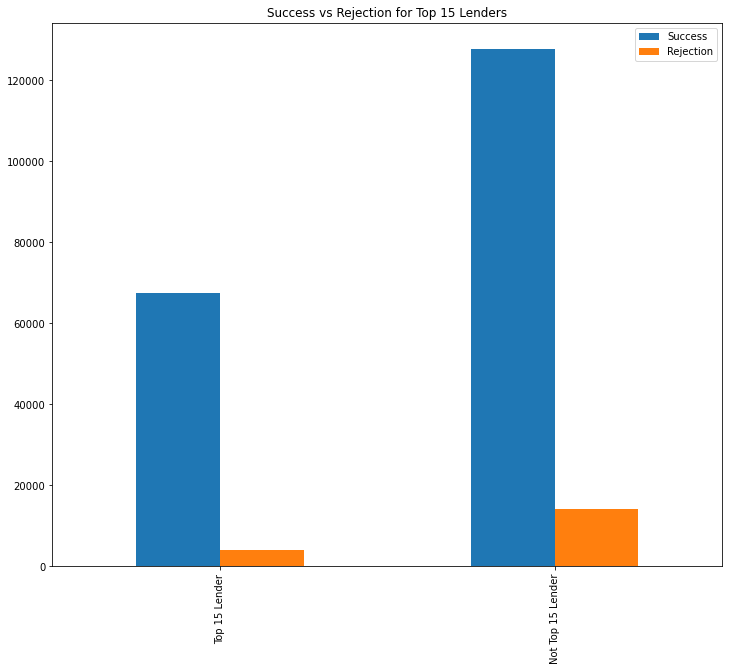

In [77]:
# Comparing top 15 previous year lender and Success Rates
graph_tl = pd.concat([pd.DataFrame([top_lenders.groupby('top15_lender_2020')['action_taken'].value_counts()[1][1],top_lenders.groupby('top15_lender_2020')['action_taken'].value_counts()[1][0]]).transpose(),
           pd.DataFrame([top_lenders.groupby('top15_lender_2020')['action_taken'].value_counts()[0][1],top_lenders.groupby('top15_lender_2020')['action_taken'].value_counts()[0][0]]).transpose()])
graph_tl.index = ['Top 15 Lender','Not Top 15 Lender']
graph_tl.columns = ['Success','Rejection']

graph_tl.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Top 15 Lenders")

In [78]:
# HYPOTHESIS TESTING : Top 15 Lender and Success
population = tl.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Top 15 Lender %','Not Top 15 Lender %','PVal']
testresult.index = ['']
testresult

,Top 15 Lender %,Not Top 15 Lender %,PVal
,94.27,89.98,0.000000


In [79]:
# Product Type #

In [80]:
# FIRST: EXPLORING CONVENTIONAL vs. FHA vs. VA Vs. FSA
loan_type = pd.DataFrame(df['action_taken'])
loan_type['Type'] = np.where(df['derived_loan_product_type'].str.contains('Conventional:'),'Conventional',
         np.where(df['derived_loan_product_type'].str.contains('VA:'),'VA',
                 np.where(df['derived_loan_product_type'].str.contains('FHA:'),'FHA',
                         np.where(df['derived_loan_product_type'].str.contains('FSA/RHS:'),'FSA','ERROR'))))

In [81]:
# Loan Type + Success Rate
lt = pd.DataFrame(loan_type.groupby('Type')['action_taken'].value_counts())
lt.columns = ['Count']
lt = lt.reset_index()
lt['%'] = 100 * lt['Count'] / lt.groupby('Type')['Count'].transform('sum')
lt = lt.sort_values(['Type', 'action_taken'], ascending = False).set_index(['Type','action_taken'])
lt

Count          %
Type         action_taken                   
VA           1               8995  90.978052
             0                892   9.021948
FSA          1               2499  88.932384
             0                311  11.067616
FHA          1              34413  88.229412
             0               4591  11.770588
Conventional 1             149210  92.254139
             0              12528   7.745861

Text(0.5, 1.0, 'Success vs Rejection for Loan Type')

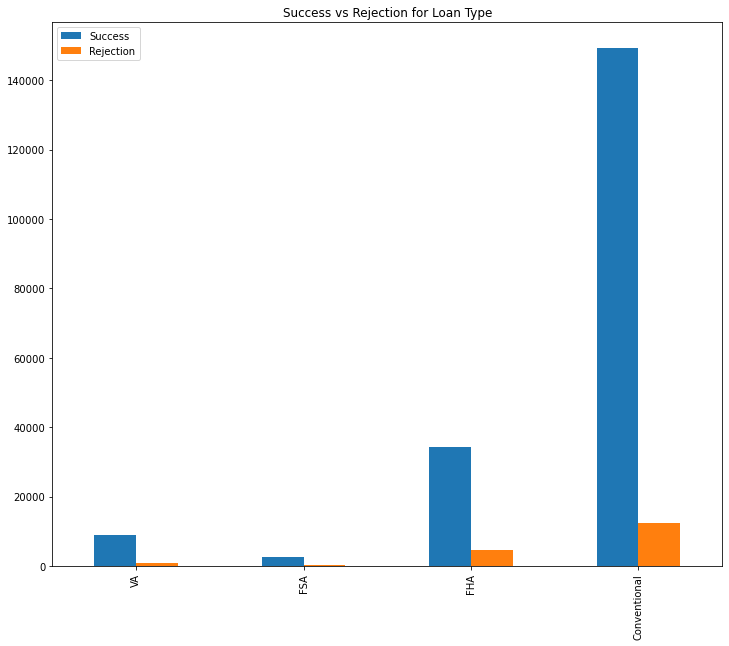

In [82]:
# Comparing Loan Types and Success Rates
graph_lt = pd.concat([pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['VA'][1],loan_type.groupby('Type')['action_taken'].value_counts()['VA'][0]]).transpose(),
           pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['FSA'][1],loan_type.groupby('Type')['action_taken'].value_counts()['FSA'][0]]).transpose(),
           pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['FHA'][1],loan_type.groupby('Type')['action_taken'].value_counts()['FHA'][0]]).transpose(),
           pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['Conventional'][1],loan_type.groupby('Type')['action_taken'].value_counts()['Conventional'][0]]).transpose()])
graph_lt.index = ['VA','FSA','FHA','Conventional']
graph_lt.columns = ['Success','Rejection']

graph_lt.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Loan Type")

In [83]:
# HYPOTHESIS TESTING : Loan Types impact on success?
population = lt.reset_index()

testresult = pd.DataFrame()
testresult['VA %'] = list([round(population.iloc[0][3],3)]) 
testresult['FSA %'] = list([round(population.iloc[2][3],3)])
testresult['FHA %'] = list([round(population.iloc[4][3],3)])
testresult['Conventional %'] = list([round(population.iloc[6][3],3)])

columnnames = ['VA vs FSA','VA vs FHA', 'VA vs Conventional','FSA vs FHA','FSA vs Conventional','FHA vs Conventional']

sample1_phat_list = [0,0,0,2,2,4,3,3,3,3,3,3]
sample2_phat_list = [2,4,6,4,6,6,3,3,3,3,3,3]
sample1_size_list = [0,0,0,2,2,4,2,2,2,2,2,2]
sample2_size_list = [2,4,6,4,6,6,2,2,2,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+6]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+6]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+6]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+6]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,VA %,FSA %,FHA %,Conventional %,VA vs FSA,VA vs FHA,VA vs Conventional,FSA vs FHA
,90.978,88.932,88.229,92.254,0.002001,0.000000,0.000012,0.291533


In [84]:
# Second: EXPLORING FIRST vs SUBORDINATE LIEN
loan_type = pd.DataFrame(df['action_taken'])
loan_type['Type'] = np.where(df['derived_loan_product_type'].str.contains(':First Lien'),'First',
         np.where(df['derived_loan_product_type'].str.contains(':Subordinate Lien'),'Subordinate','ERROR'))

In [85]:
# Loan Type + Success Rate
lt = pd.DataFrame(loan_type.groupby('Type')['action_taken'].value_counts())
lt.columns = ['Count']
lt = lt.reset_index()
lt['%'] = 100 * lt['Count'] / lt.groupby('Type')['Count'].transform('sum')
lt = lt.sort_values(['Type', 'action_taken'], ascending = False).set_index(['Type','action_taken'])
lt

Count          %
Type        action_taken                   
Subordinate 1               3875  91.672581
            0                352   8.327419
First       1             191242  91.410627
            0              17970   8.589373

Text(0.5, 1.0, 'Success vs Rejection for Loan Type')

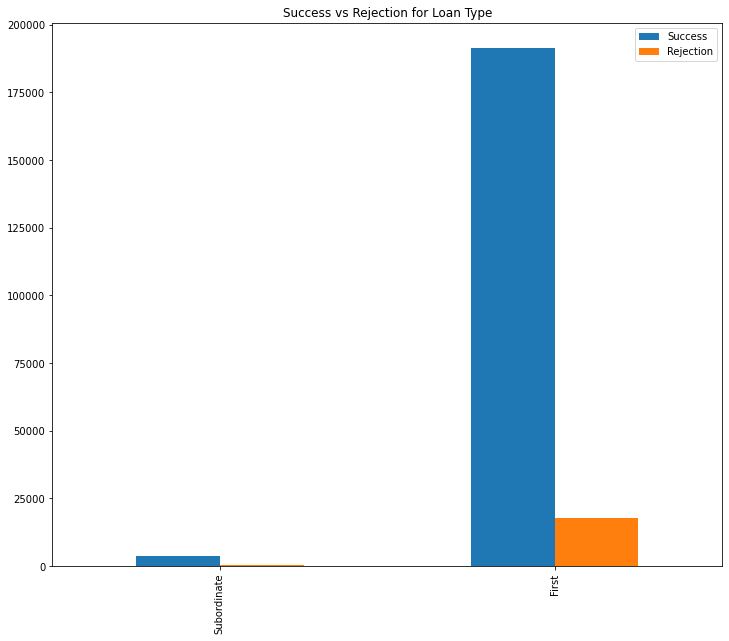

In [86]:
# Comparing Loan Types Property Success Rates
graph_lt = pd.concat([pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['Subordinate'][1],loan_type.groupby('Type')['action_taken'].value_counts()['Subordinate'][0]]).transpose(),
           pd.DataFrame([loan_type.groupby('Type')['action_taken'].value_counts()['First'][1],loan_type.groupby('Type')['action_taken'].value_counts()['First'][0]]).transpose()])
graph_lt.index = ['Subordinate','First']
graph_lt.columns = ['Success','Rejection']

graph_lt.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Loan Type")

In [87]:
# HYPOTHESIS TESTING : Lien status and Success
population = lt.reset_index()

sample1_phat = population.iloc[0][3]/100
sample2_phat = population.iloc[2][3]/100
sample1_size = population.iloc[0][2]
sample2_size = population.iloc[2][2]
phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
pval = st.norm.sf(abs(zscore))*2
testresult = pd.DataFrame([round(sample1_phat*100,3),round(sample2_phat*100,3),format(pval,'f')]).transpose()
testresult.columns = ['Subordinate %','First %','PVal']
testresult.index = ['']
testresult

,Subordinate %,First %,PVal
,91.673,91.411,0.564415


In [88]:
# LOAN AMOUNT #

In [89]:
# DROP ALL THAT HAVE AN EXEMPT / NOT NUMERIC
numeric_loan = pd.DataFrame(df['action_taken'])
numeric_loan['loan_amount'] = pd.to_numeric(df['loan_amount'], errors='coerce')
numeric_loan = numeric_loan.dropna().reset_index(drop = True)
len(df)-len(numeric_loan)

0

In [90]:
# Creating Buckets for LOAN AMOUNT
low = numeric_loan['loan_amount'].quantile(.33)
medium = numeric_loan['loan_amount'].quantile(.66)
numeric_loan['Loan_Bracket'] = np.where(numeric_loan['loan_amount']<=low,'Low',
         np.where((numeric_loan['loan_amount']>low)&(numeric_loan['loan_amount']<medium),'Medium',
                 np.where(numeric_loan['loan_amount']>=medium,'High','ERROR')))

print('Low: Loan Value <=',low)
print('Medium: Loan Value >',low,'and <',medium)
print('High: Loan Value >=',medium)

Low: Loan Value <= 165000.0
Medium: Loan Value > 165000.0 and < 285000.0
High: Loan Value >= 285000.0


In [91]:
# Loan Bracket + Success Rate
lb = pd.DataFrame(numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts())
lb.columns = ['Count']
lb = lb.reset_index()
lb['%'] = 100 * lb['Count'] / lb.groupby('Loan_Bracket')['Count'].transform('sum')
lb = lb.sort_values(['Loan_Bracket', 'action_taken'], ascending = False).set_index(['Loan_Bracket','action_taken'])
lb

Count          %
Loan_Bracket action_taken                  
Medium       1             60748  92.358683
             0              5026   7.641317
Low          1             65134  87.781671
             0              9066  12.218329
High         1             69235  94.242156
             0              4230   5.757844

Text(0.5, 1.0, 'Success vs Rejection for Loan Amount Bracket')

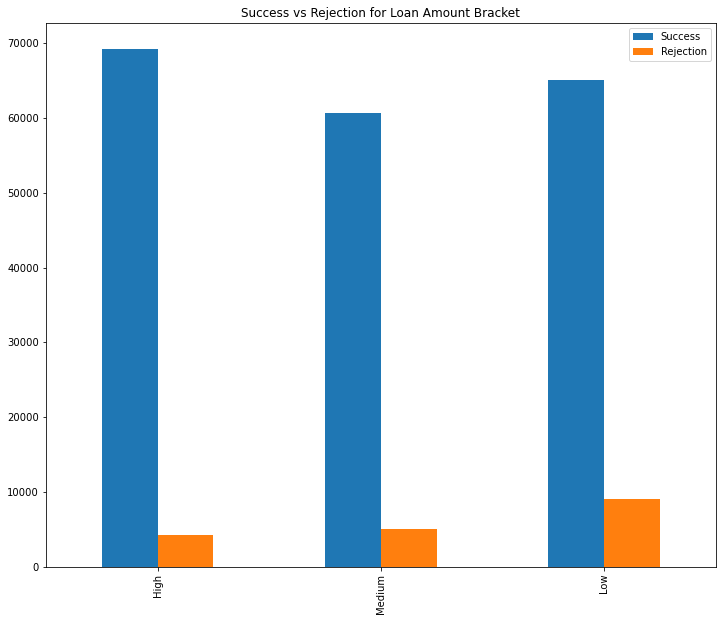

In [92]:
# Comparing Loan Brackets Success Rates
graph_lb = pd.concat([pd.DataFrame([numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['High'][1],numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['Low'][1],numeric_loan.groupby('Loan_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_lb.index = ['High','Medium','Low']
graph_lb.columns = ['Success','Rejection']

graph_lb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Loan Amount Bracket")

In [93]:
# HYPOTHESIS TESTING : loan Brackets impact on success?
population = lb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.359,87.782,94.242,0.000000,0.000000,0.000000


In [94]:
# Loan to Value #

In [95]:
# DROP ALL THAT HAVE AN EXEMPT / NOT NUMERIC
numeric_loan_val = pd.DataFrame(df['action_taken'])
numeric_loan_val['loan_to_value_ratio'] = pd.to_numeric(df['loan_to_value_ratio'], errors='coerce')
numeric_loan_val = numeric_loan_val.dropna().reset_index(drop = True)
len(df)-len(numeric_loan_val)

7079

In [96]:
# Creating Buckets for Loan to Values
low = numeric_loan_val['loan_to_value_ratio'].quantile(.33)
medium = numeric_loan_val['loan_to_value_ratio'].quantile(.66)
numeric_loan_val['Value_Bracket'] = np.where(numeric_loan_val['loan_to_value_ratio']<=low,'Low',
         np.where((numeric_loan_val['loan_to_value_ratio']>low)&(numeric_loan_val['loan_to_value_ratio']<medium),'Medium',
                 np.where(numeric_loan_val['loan_to_value_ratio']>=medium,'High','ERROR')))

print('Low: Loan to Value <=',low)
print('Medium: Loan to Value >',low,'and <',medium)
print('High: Loan to Value >=',medium)

Low: Loan to Value <= 80.0
Medium: Loan to Value > 80.0 and < 95.0
High: Loan to Value >= 95.0


In [97]:
# Value Bracket + Success Rate
lvb = pd.DataFrame(numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts())
lvb.columns = ['Count']
lvb = lvb.reset_index()
lvb['%'] = 100 * lvb['Count'] / lvb.groupby('Value_Bracket')['Count'].transform('sum')
lvb = lvb.sort_values(['Value_Bracket', 'action_taken'], ascending = False).set_index(['Value_Bracket','action_taken'])
lvb

Count          %
Value_Bracket action_taken                  
Medium        1             32866  92.229550
              0              2769   7.770450
Low           1             72250  95.054533
              0              3759   4.945467
High          1             85685  90.465180
              0              9031   9.534820

Text(0.5, 1.0, 'Success vs Rejection for Loan to Value Bracket')

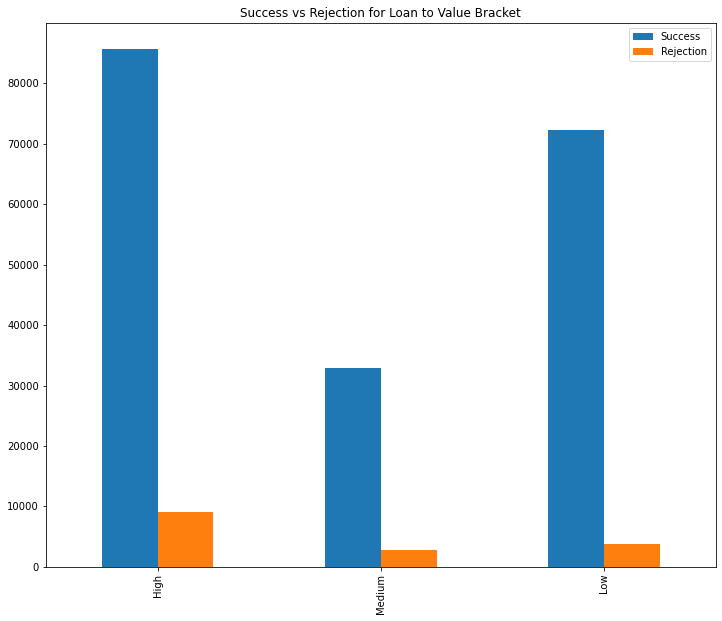

In [98]:
# Comparing Value Brackets Success Rates
graph_lvb = pd.concat([pd.DataFrame([numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['High'][1],numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['High'][0]]).transpose(),
           pd.DataFrame([numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][1],numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['Medium'][0]]).transpose(),
           pd.DataFrame([numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][1],numeric_loan_val.groupby('Value_Bracket')['action_taken'].value_counts()['Low'][0]]).transpose()])
graph_lvb.index = ['High','Medium','Low']
graph_lvb.columns = ['Success','Rejection']

graph_lvb.plot(kind = 'bar', figsize = (12,10))
plt.title("Success vs Rejection for Loan to Value Bracket")

In [99]:
# HYPOTHESIS TESTING : Loan to Value Brackets impact on success?
population = lvb.reset_index()

testresult = pd.DataFrame()
testresult['Medium %'] = list([round(population.iloc[0][3],3)]) 
testresult['Low %'] = list([round(population.iloc[2][3],3)])
testresult['High %'] = list([round(population.iloc[4][3],3)])

columnnames = ['Medium vs Low','Medium vs High', 'Low vs High']

sample1_phat_list = [0,0,2,3,3,3]
sample2_phat_list = [2,4,4,3,3,3]
sample1_size_list = [0,0,2,2,2,2]
sample2_size_list = [2,4,4,2,2,2]


for x in range(int(len(population)/2)):
    sample1_phat = population.iloc[sample1_phat_list[x]][sample1_phat_list[x+3]]/100
    sample2_phat = population.iloc[sample2_phat_list[x]][sample2_phat_list[x+3]]/100
    sample1_size = population.iloc[sample1_size_list[x]][sample1_size_list[x+3]]
    sample2_size = population.iloc[sample2_size_list[x]][sample2_size_list[x+3]]
    phat = (sample1_phat*sample1_size+sample2_phat*sample2_size)/(sample1_size+sample2_size)
    zscore = (sample1_phat - sample2_phat)/np.sqrt(phat*(1-phat)*((1/sample1_size)+(1/sample2_size)))    
    pval = st.norm.sf(abs(zscore))*2
    testresult[columnnames[x]] = list([format(pval,'f')])

testresult.index = ['']
testresult

,Medium %,Low %,High %,Medium vs Low,Medium vs High,Low vs High
,92.23,95.055,90.465,0.000000,0.000000,0.000000


In [100]:
#####################################################################

In [101]:
# CLEANING DATA FOR MODEL: FEATURE ENGINEERING

In [102]:
# CHECKING THE VALUE COUNTS FOR EACH COLUMN
#model.iloc[:, [51]].value_counts()

In [103]:
model = df
# turning easy columns into dummy variables
easylist = ['derived_msa-md','conforming_loan_limit','derived_loan_product_type',
           'derived_dwelling_category','business_or_commercial_purpose','hoepa_status','occupancy_type',
           'total_units','debt_to_income_ratio','applicant_credit_score_type','co-applicant_credit_score_type',
           'applicant_ethnicity-1','co-applicant_ethnicity-1','applicant_ethnicity_observed','co-applicant_ethnicity_observed',
            'applicant_race-1','co-applicant_race-1','applicant_race_observed','co-applicant_race_observed',
            'applicant_sex','co-applicant_sex','applicant_sex_observed','co-applicant_sex_observed','applicant_age','co-applicant_age',
            'submission_of_application','aus-1']
for x in range(len(easylist)):
    model = pd.get_dummies(model,drop_first = True, columns = [easylist[x]])


In [104]:
# CHECK FOR NULLS
dropnull = model.isnull().sum()[model.isnull().sum()>0].index.tolist()
for x in range(len(dropnull)):
    model = model[~model[dropnull[x]].isnull()]

In [105]:
model.isnull().sum().max()

0

In [106]:
# EXPORT MODEL DF FOR ML and DL
#model.to_csv('IL_Loan_Outcome.csv')